In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import networkx as nx 
import multiprocessing as mp


from scipy.ndimage import gaussian_filter

from skimage.segmentation import watershed
from skimage.morphology import disk
from skimage import img_as_ubyte
from skimage.measure import label, regionprops, euler_number
from skimage.future.graph import RAG
from sknetwork.path import distance
from skimage import util
from skimage import filters

from tqdm import tqdm

from cvxopt import solvers, matrix, div, log, exp, mul

In [2]:
#get image and define the image space
image = plt.imread('../images/dna-images/gnf/dna-1.png')[...,0]

## Algorithm I

In [3]:
def generate_fragments(img,std_dev,int_threshold,min_seed_dist,max_search_depth,max_frag_dist):
    img = img_as_ubyte(img)
    #smooth image with gausian filter
    g = gaussian_filter(img,std_dev)
    #flatten the lower 50 percentile of the gaussian filter to 0 (for background)
    g[g < np.percentile(g, 50)] = 0
    
    #Fehlerabfangen
    if std_dev < 0:
        raise ValueError("smoothing strength needs to be positive")
    if int_threshold > 1 or int_threshold < 0:
        raise ValueError("relative intensity threshold needs to be between 0 and 1")
    if min_seed_dist < 1:
        raise ValueError("min seed distance needs to be >= 1")
    if max_search_depth < 0:
        raise ValueError("maximum search error needs to be positive")
    if max_frag_dist < 0:
        raise ValueError("maximum fragments distance needs zo be positive")
        
    #Create Delta Ball
    B = disk(min_seed_dist)
    #Set the markers in the Image according to the formula (P is an image)
    P = (g==filters.rank.maximum(g,B)) & ((1-int_threshold)*g >= filters.rank.minimum(g,B))
    #Fuse adjacient markers and label each group of markers
    g_markers = label(P)
    #Get the regions of the markers to access centroid later
    PI = regionprops(g_markers)

    #Create Watershed regions
    Omega = watershed(util.invert(g),markers=g_markers)
    #Create the adjacency graph of the labeled image
    G = RAG(Omega,connectivity=2)

    #Remove edges if centroids are to far away
    for edge in G.edges():
        if np.linalg.norm(np.array(PI[edge[0]-1].centroid) - np.array(PI[edge[1]-1].centroid)) > max_frag_dist:
            G.remove_edge(edge[0],edge[1])

    S = set()
    #iterate over all conected components (cc)
    for nodes_in_cc in nx.algorithms.connectivity.edge_kcomponents.k_edge_subgraphs(G,1):
        #Set the subgraph of curent cc
        H = G.subgraph(nodes_in_cc)
        #Loop over the nodes of the subgraph
        for v in tqdm(nodes_in_cc):
            #Add the isolated region of the curent node
            if euler_number(Omega == v) == 1:
                S.add(frozenset([v]))
            #Loop over the distance from the curent node within the graph
            for distance in range(1,max_search_depth+1):
                #Get a dictonary containg the distance from curent node
                distance_from_origin = nx.single_source_shortest_path_length(H, v,cutoff=distance)
                #Loop over the amount of nodes
                for node_amount in range(distance,len(distance_from_origin.values())):
                    #Loop over all subsets of nodes that contain v and contain node_amount of nodes
                    for node_subset in itertools.combinations([node for node in distance_from_origin.keys()], node_amount):
                        node_subset = set([v]).union(set(node_subset))
                        #Check other requirments and add the node set to S if they are fullfilled
                        if frozenset(node_subset) not in S:
                            if nx.is_connected(H.subgraph(node_subset)):
                                #check that the merge of the regions is simply connected
                                sub_img = np.zeros_like(Omega, dtype = bool)
                                for region_label in node_subset:
                                    sub_img += Omega == region_label
                                if euler_number(sub_img) == 1:
                                     S.add(frozenset(node_subset))

    return Omega,S

###  Test: Algorithm I

In [4]:
#testing Alg I
Omega,S = generate_fragments(image,16,0.01,20,2,100)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.86it/s]


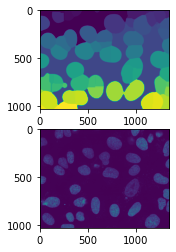

In [5]:
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
imgplot = plt.imshow(Omega)
ax = fig.add_subplot(2, 1, 2)
imgplot = plt.imshow(image)

In [6]:
print(S)

{frozenset({17, 10, 11, 14}), frozenset({2, 3}), frozenset({17, 18, 11, 14}), frozenset({32}), frozenset({49}), frozenset({17, 10, 14}), frozenset({56, 57, 58, 54}), frozenset({59, 52, 53, 55}), frozenset({10}), frozenset({59, 55}), frozenset({18}), frozenset({67, 68}), frozenset({9, 2}), frozenset({9, 2, 3, 4}), frozenset({3, 4}), frozenset({18, 11, 14}), frozenset({10, 11, 14}), frozenset({23}), frozenset({33}), frozenset({24}), frozenset({33, 28, 36}), frozenset({17, 20, 14}), frozenset({17, 19, 20, 10, 14}), frozenset({56, 49, 58, 57}), frozenset({17, 10, 19, 14}), frozenset({17, 18, 19, 20, 11, 14}), frozenset({11, 14}), frozenset({16}), frozenset({56, 49, 54, 57}), frozenset({58}), frozenset({17, 19, 20}), frozenset({54}), frozenset({44}), frozenset({47}), frozenset({68}), frozenset({37}), frozenset({46}), frozenset({49, 54, 56, 57, 58, 47}), frozenset({56, 54}), frozenset({40, 39}), frozenset({50, 44, 45, 60}), frozenset({17, 18, 19, 10, 11, 14}), frozenset({2}), frozenset({34})

In [7]:
len(S)

177

## Computation of f

We use a second-order solver for non-linear unconstrained convex problem. To do so, we define $\theta^T = [a_1, a_2, a_3, b_1, b_2, c]$ and as such define for a pixel $x \in R$ (R = region.coords) $\subset \mathbb{R}^2$ 
$$\begin{align*}
s(x, \theta) &= x^T \begin{pmatrix} a_1 & a_3 \\ a_3 & a_2 \end{pmatrix} x + \begin{pmatrix} b_1, b_2 \end{pmatrix} \begin{pmatrix} x_1 \\ x_2 \end{pmatrix} + c \\
&= x^T \begin{pmatrix} \theta[0] & \theta[2] \\ \theta[2] & \theta[1] \end{pmatrix} x + \begin{pmatrix} \theta[3], \theta[4] \end{pmatrix} \begin{pmatrix} x_1 \\ x_2 \end{pmatrix} + \theta[5] \\
&= a_1 x_1^2 + a_2x_2^2 + 2a_3x_1x_2 + b_1x_1 + b_2x_2 + c \\
&= \nabla^T s(x) * \theta 
\end{align*}$$
for $\nabla^T s(x) = [x_1^2, x_2^2, 2x_1x_2, x_1, x_2, 1]$

The following is a brief explanation of the used data structures and especially their dimensions to help the reader better undertstand the function J_energy:

- y has size region.area x 1. Each element corresponds to $g(x) - \tau$ for $x$ two-dim coordinates of a pixel in region.
- delta_s is a region.area x 6 matrix. Each row corresponds to $\nabla^T s(x)$ for $x$ two-dim coordinates of a pixel in region.
$$\text{delta_s} = \begin{pmatrix} \nabla^T s(x_0) \\ \nabla^T s(x_1) \\ ... \\ \nabla^T s(x_{region.area}) \end{pmatrix}$$
- s is a [region.area x 1] matrix. Each row corresponds to the inner product $s(x, \theta) = \nabla^T s(x) * \theta$ for $x$ two-dim coordinates of a pixel in region.
- phi is a [region.area x 1] matrix. Each row corresponds to the evaluation of the function $\phi(y, s(x, \theta)) = \log(1+\exp(-y(x)*s(x, \theta))).$ Here we remark that the functions MULT, EXP and LOG operate on matricies element-wise.
- J is the sum of the vector phi, and as such corresponds to $J(\theta) = \sum_{x \in R} \phi(y_x; s(x, \theta))$ and is a scalar.

We move on to the definition of the Jacobian of J. To that end we define:
- kappa, matrix of size [region.area x 1]. Each row corresponds to $\kappa_{x, \theta} = \frac{1}{1 + \exp(y_x s(x; \theta))}$ for $x$ two-dim coordinates of a pixel in region.
- DJ, the Jacobian of J, matrix of size [6x1]. It is constructed as follows:
    - We multiply y and kappa element-wise. 
    - To this vector we multiply a [1x6] one-vector. This gives us a [region.area x 6] matrix, where each row is identical to y*kappa.
    - This Matrix we inturn multiply element-wise with delta_s. As such we obtain a [region.area x 6] matrix, where each row consists of the vector $y_x * \kappa_{x, \theta} * \nabla^T s(x)$ for $x$ two-dim coordinates of a pixel in region. 
    - as I found no function to only sum over rows, we multiply the last matrix from the right with the [1xregion.area] vector, which acts as a row-sum operator.
    
We move on to the Definition of the Hessian Matrix. To that end, we define:
- nu, matrix of size [region.area x 1], as the element-wise multiplication of y^2 * (kappa - kappa^2).
- eta, matrix of size [region.area x 6 X 6] (interpreted as a matrix of size [(region.area * 6) x 6] as matrix only accepts one- or two-dim arrays), each 6x6 matrix is the outer product of $\nabla ^T s(x)$ and $\nabla s(x)$ multiplied with the corresponding scalar $\nu_x$ for $x$ two-dim coordinates of a pixel in region.
- SumMatrix, a [(region.area*6) x 6] matrix, pasting the 6-Identitymatrix region.area-times under each other. When multiplied to the left of a eta, it acts as a sum operator for region.area many 6x6 matricies.

In [8]:
def J_energy(Omega, image, regions):
    
    #coords = [(i,j) for i in range(image.shape[0]) for j in range(image.shape[1])]
    #area = image.size
    
    #regions is a list of skimage.measure regions out of regionprops
    n = len(regions)
    area = 0
    sub_img = np.zeros_like(Omega, dtype = bool)
    for reg in regions:
        area += reg.area
        sub_img += Omega == reg.label
    coords = regions[0].coords
    for i in range(1, n):
        coords = np.append(coords, regions[i].coords, axis = 0)
    
    #define tau
    tau = filters.threshold_otsu(image[sub_img])
    #define y_x for every element in the region
    y = matrix(np.array([image[x[0], x[1]] - tau for x in coords], dtype = np.double))
    #define nable s(x) for each element
    delta_s = matrix(np.array([[x[0]**2, x[1]**2, 2*x[0]*x[1], x[0], x[1], 1] for x in coords]), (area, 6))
    def F(theta = None, z = None):
        # choose starting point and as such define dimension of theta
        if theta is None: return 0, matrix(0.0, (6,1))
        # s contains region.area many rows, each row contains a scalar.
        s = delta_s * theta
        #print(max(s))
        phi = log(1 + exp(-mul(y,s)))
        #print(max(phi))
        J = sum(phi)
        kappa = div(1, 1+exp(mul(y,s)))
        DJ = matrix(1, (1, area)) * (-mul(mul(y, kappa) * matrix(1, (1, 6)), delta_s))
        if z is None: return J, DJ
        nu = mul(y**2, kappa - kappa**2)
        #define matrix to multiply from the right for summation
        SumMatrix = matrix(np.tile([[1,0,0,0,0,0], 
                                    [0,1,0,0,0,0], 
                                    [0,0,1,0,0,0], 
                                    [0,0,0,1,0,0], 
                                    [0,0,0,0,1,0], 
                                    [0,0,0,0,0,1]], area))
        eta = matrix([delta_s[i,:].T * delta_s[i,:] * nu[i] for i in range(area)])
        H = z[0]* SumMatrix * eta
        return J, DJ, H
    solv = solvers.cp(F)
    return solv['primal objective'], solv['x'].T

In [9]:
solvers.options['show_progress'] = True
solvers.options['maxiters'] = 100
solvers.options['feastol'] = 1e-2
#solvers.options['abstol'] = 20
#solvers.options['reltol'] = 30
#use for a single region
#J_energy(Omega, image, [regionprops(Omega)[0]])

#test for a single element from S
Z = list(S)
regions = []
for i in list(Z[45]):
    regions.append(regionprops(Omega)[i-1]) #beware: region labeling starts at 1!
J_energy(Omega, image, regions)

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  8.2193e+03  1e+00  1e+00  1e+00
 1: -4.0201e+02  3.2084e+03  1e-02  4e-01  2e-01
 2:  1.1838e+03  1.9133e+03  1e-04  9e-02  7e-02
 3:  8.7029e+02  1.2315e+03  1e-06  4e-02  3e-02
 4:  6.3622e+02  8.4059e+02  1e-08  2e-02  1e-02
 5:  4.8953e+02  6.0951e+02  1e-10  1e-02  5e-03
 6:  3.9623e+02  4.6841e+02  1e-12  9e-03  2e-03
Optimal solution found.


(396.2301212253594, <1x6 matrix, tc='d'>)

In [10]:
solvers.options['show_progress'] = False
solvers.options['feastol'] = 1e-2
Z = list(S)
f = np.zeros(len(Z))
theta = matrix(np.zeros((len(Z),6)),(len(Z),6))

for k in tqdm(range(len(Z))):
    regions = []
    for i in list(Z[k]):
        regions.append(regionprops(Omega)[i-1]) #beware: region labeling starts at 1!
    try:
        solvers.options['feastol'] = 1e-7
        f[k],theta[k,:] = J_energy(Omega, image, regions)
    except:
        solvers.options['feastol'] = 1e-2
        f[k],theta[k,:] = J_energy(Omega, image, regions)

100%|████████████████████████████████████████████████████████████████████████████████| 177/177 [10:20<00:00,  3.51s/it]


In [11]:
alpha = np.median(f)

## Algorithm II

In [12]:
def global_solution(f,alpha,Omega,S):
    #Set Variables we dont need Z but f_used
    n = len(S) 
    u = np.zeros(n)
    V = set()
    Z = set(S)
    f_used = np.copy(f)
    #First Loop over copy of Omega
    for Zk in S:
        V = V.union(Zk)
    while V != set():
        c = np.zeros(n)
        #Loop over number of Subgraphs in S
        for k in range(n):
            #Set intersection length
            Zk_V = len(V.intersection(set(S[k])))
            #Set c if intersection is non empty 
            if  Zk_V !=0:
                c[k] = (f[k] + alpha) / Zk_V
            #Else set it to nan to ignore it
            else:
                c[k] = np.nan
        #Get the argmin of c
        k_min = np.nanargmin(c)
        #Set u of argmin to 1
        u[k_min] = 1 
        #Remove the nodes of Z_k
        V -= S[k_min]
    
    #Second loop over not used elements of f
    while Z != set():
        #Set current element of interest k_prim
        k_prim = np.nanargmin(f_used)
        #check if u[_k_prim hasnt been used in first loop
        if u[k_prim]==0:
            #crate subvector v of u
            v = np.copy(u)
            #loop over all elements of u that are non zero
            for ind in np.nonzero(u)[0]:
                #check if Z_ind is subset of Z_kprim
                if not S[ind].issubset(S[k_prim]):
                    #if not set v to 0 to ignore it in the union
                    v[ind] = 0
            #check if union of all left subsets is equal to Z_kprim
            union = set()
            for k in np.nonzero(v)[0]:
                for label in S[k]:
                    union.add(label)
            if set(S[k_prim]) == union:
                #check smth...
                if f[k_prim]+alpha < np.dot(v,f + (alpha*np.ones(n))):
                    #Set u values of the used subsets to 0 and the union to 1
                    u -= v
                    u[k_prim] = 1
        #make f equal to nan for the used region
        f_used[k_prim]=np.nan
        Z -= {S[k_prim]}
    return u

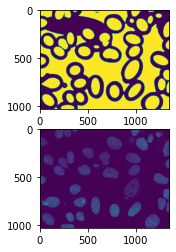

In [13]:
u = global_solution(f, alpha, Omega, Z)
segmentation = np.zeros_like(image)
for k in range(len(u)):
    if u[k]==1:
        regions = []
        for i in Z[k]:
            regions.append(regionprops(Omega)[i-1]) 
        n = len(regions)
        area = 0
        sub_img = np.zeros_like(Omega, dtype = bool)
        for reg in regions:
            area += reg.area
            sub_img += Omega == reg.label
        coords = regions[0].coords
        for i in range(1, n):
            coords = np.append(coords, regions[i].coords, axis = 0)
        delta_s = matrix(np.array([[x[0]**2, x[1]**2, 2*x[0]*x[1], x[0], x[1], 1] for x in coords]), (area, 6))
        s = delta_s * theta[k,:].T
        for i,pixel in enumerate(coords ,start= 0):
            if s[i]>=0:
                segmentation[pixel[0],pixel[1]] = 1

fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
imgplot = plt.imshow(segmentation)
ax = fig.add_subplot(2, 1, 2)
imgplot = plt.imshow(image)